# **Soy Price Forecast**

This project aims to forecast the price of the brazilian soybeans 60 kilogram bag using only the time series of the price it self. The data was collected from CEPEA (Center for Advanced Studies on Applied Economics) and ranges from 13/03/2006 to 10/04/2025

## Packages and Data


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

In [29]:
data = pd.read_csv('data.csv')

## Preprocessing

First, i will change the names of the features to english, since the data was aquired from a brazilian source, the names are in portuguese

In [30]:
df = data.rename(columns={'data': 'date', 'valor_real': 'price_BRL', 'valor_dolar' : 'price_USD'})

In [31]:
df['date'] = pd.to_datetime(df['date'], dayfirst = True)

i will set the date as the index since we are working with a time series dataset

In [32]:
missing = df.isnull().sum()
duplicated = df.duplicated().sum()
print(f"Total Missing Values: \n{missing}\nTotal Duplicated Values: {duplicated}")

Total Missing Values: 
date         0
price_BRL    0
price_USD    0
dtype: int64
Total Duplicated Values: 0


Since we dont have any missing or duplicated values, we could move on to the EDA.

## EDA

In [33]:
df.head()

,date,price_BRL,price_USD
0,2006-03-13,27.66,12.96
1,2006-03-14,27.45,12.91
2,2006-03-15,27.58,13.00
3,2006-03-16,26.97,12.78
4,2006-03-17,26.96,12.68


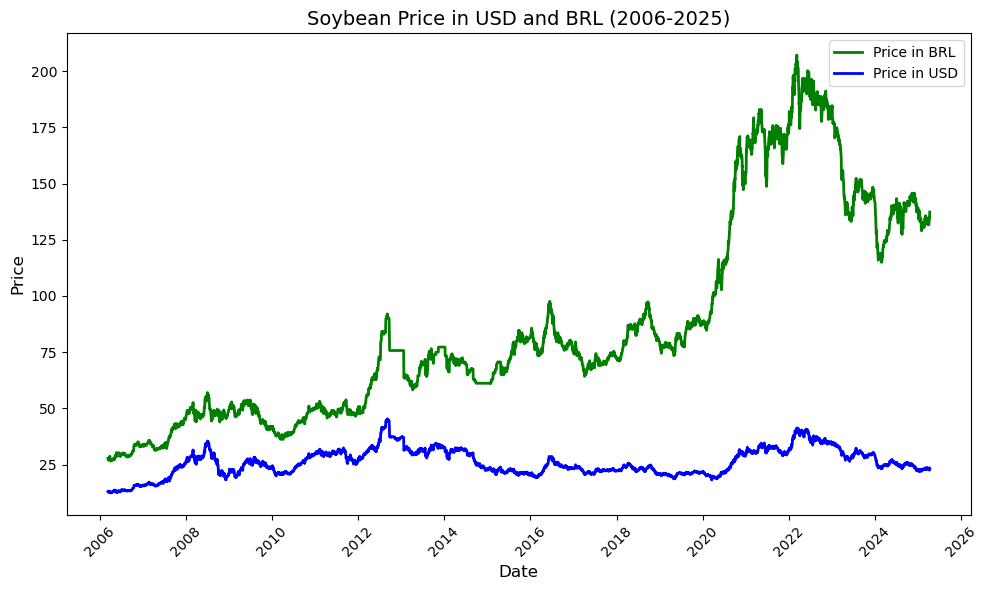

In [34]:
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['price_BRL'], label='Price in BRL', color='green', linewidth=2)
plt.plot(df['date'], df['price_USD'], label='Price in USD', color='blue', linewidth=2)

plt.title('Soybean Price in USD and BRL (2006-2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The price in BRL has a spike in 2020 beacause during the COVID-19 pandemicthe brazilian real has plummeted, with that in mind, is safer for our analysis that we use the price in USD 

In [35]:
df = df.drop(columns=['price_BRL'])

### Seasonality Analysis

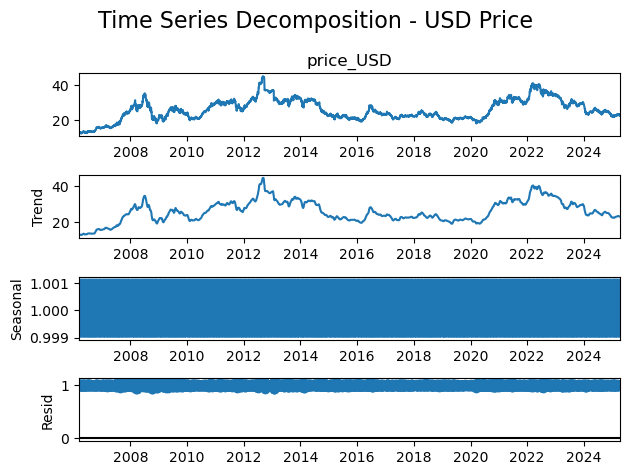

In [36]:
df_ts = df.set_index('date').sort_index()

result = seasonal_decompose(df_ts['price_USD'], model='multiplicative', period=12)

result.plot()
plt.suptitle('Time Series Decomposition - USD Price', fontsize=16)
plt.tight_layout()
plt.show()

I will move on to use a OLS with monthly dummies to verify if any month has a seazonal impact on the price

In [37]:
df['month'] = df['date'].dt.month
dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)

X = dummies
y = df['price_USD']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_USD   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.434
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           8.92e-05
Time:                        09:09:30   Log-Likelihood:                -15221.
No. Observations:                4757   AIC:                         3.047e+04
Df Residuals:                    4745   BIC:                         3.054e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7307      0.294     87.472      0.0

- Prices tend to be significantly higher in July, August, and September compared to January. This make sense, as the harvest takes place between January and April, scarcity begins at that time. The price variation ranges from 0.91-0.95 USD
- F-statistic 3.434 and p-value < 0.05 indicates that the model is statisticaly significant
- Omnibus with a low p-value indicates that the values dont have a normal distribution

At this point is important to find out if the series is stationary or non-stationary since this have a huge influence in which model will be used in the forecast

In [45]:
serie = df['price_USD'].dropna()

def print_adf_test(series):
    stat, pvalue, _, _, crit_values, _ = adfuller(series)
    print("=== Teste ADF ===")
    print(f"Estatística: {stat:.4f}")
    print(f"p-valor: {pvalue:.4f}")
    print("Críticos:")
    for key, value in crit_values.items():
        print(f"  {key}: {value:.4f}")
    print("-> Rejects H0 if p < 0.05 (series is stationary)\\n")

def print_kpss_test(series):
    stat, pvalue, _, crit_values = kpss(series, regression='c', nlags='auto')
    print("=== Teste KPSS ===")
    print(f"Estatística: {stat:.4f}")
    print(f"p-valor: {pvalue:.4f}")
    print("Críticos:")
    for key, value in crit_values.items():
        print(f"  {key}: {value:.4f}")
    print("-> Rejects H0 if p < 0.05 (series is non-stationary)\n")

def print_pp_test(series):
    result = PhillipsPerron(series)
    print("=== Teste Phillips-Perron ===")
    print(f"Estatística: {result.stat:.4f}")
    print(f"p-valor: {result.pvalue:.4f}")
    print("Críticos:")
    for key, value in result.critical_values.items():
        print(f"  {key}: {value:.4f}")
    print("-> Rejects H0 if p < 0.05 (series is stationary)\\n")

print_adf_test(serie)
print_kpss_test(serie)
print_pp_test(serie)

=== Teste ADF ===
Estatística: -3.0499
p-valor: 0.0305
Críticos:
  1%: -3.4805
  5%: -2.8835
  10%: -2.5785
-> Rejects H0 if p < 0.05 (series is stationary)\n
=== Teste KPSS ===
Estatística: 0.2834
p-valor: 0.1000
Críticos:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
-> Rejects H0 if p < 0.05 (series is non-stationary)

=== Teste Phillips-Perron ===
Estatística: -3.0882
p-valor: 0.0274
Críticos:
  1%: -3.4805
  5%: -2.8835
  10%: -2.5785
-> Rejects H0 if p < 0.05 (series is stationary)\n


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


All the tests indicate that the series **is stationary**